# Summary of last lecture

Yesterday I showed how to rigorously compute an approximation of the invariant density of a deterministic dynamical system that satisfies a Lasota-Yorke inequality through an a posteriori estimate of the mixing rates of the Ulam operator.

I showed how it is possible to estimate the invariant density, how to use the coarse fine estimates to get mixing rates for a finer operator and how it is possible to estimate the BV mixing rates for the abstract operator.

There is an additional notebook, where it is possible to see how to use Ulam with random dynamical systems with uniform noise.

## Random dynamical systems with Gaussian noise 

Today I will introduce the tecniques developed in [Galatolo - Lopez Vereau - Marangio - Nisoli Efficient computation of stationary measures and the Lyapunov Landscape for families random dynamical systems with smooth additive noise](https://arxiv.org/abs/2508.03895v1) to approximate the annealed transfer operator of systems with additive smooth noise.
Due to the regularity of the noise, the annealed transfer operator preserves an highly regular space and this allows us to approximate efficiently the annealed transfer operator by using a Galerkin approximation.
This is the Ph.D. thesis work of Charles Edgar Lopez Vereau, which developed an efficient algorithm for rigorous phase space exploration of the *Lyapunov landscape*. 

We start by loading an implementation of a rigorous linear algebra library, called BallArithmetic.

In [ ]:
#import Pkg; 
#Pkg.add(path = "https://github.com/JuliaBallArithmetic/BallArithmetic.jl.git")

    Updating git-repo `https://github.com/JuliaBallArithmetic/BallArithmetic.jl.git`
   Resolving package versions...
  No Changes to `C:\Users\isaia\Code\HSI2025\Project.toml`
  No Changes to `C:\Users\isaia\Code\HSI2025\Manifest.toml`


We will work with the following family of functions
\begin{align}
T_{\alpha,\beta}(x)=T(x,\alpha,\beta)&=\beta - (1+\beta)|x|^{\alpha},
\end{align}
where $\alpha\geq 1$, $\beta\in (-1,1]$ and $x\in [-1,1]$.
We will study the random dynamical system the family with Gaussian additive noise with variance $\sigma$ i.e
\begin{align*}
    X_{n+1}=\tau(T_{\alpha,\beta}(X_n)+\Omega_{\sigma}(n))
\end{align*}
where $\Omega_{\sigma}(n)$ are random variables i.i.d with Gaussian distribution and $\tau:\mathbb{R}\rightarrow [-1,1]$ boundary condition map $\tau(x)=x - 2\lfloor \frac{x +1}{2} \rfloor$, is the representative in $[-1, 1)$ of $x$ with repect to $x \sim y$ if $x-y=2k$, $k\in \mathbb{Z}$.

The following two images are from the paper with Stefano, Charles and Luigi, where we computed the Lyapunov exponent on a fine grid, to explore the parameter space.


![image](Landscape.png)

![image](Table.png)

![image](two_point.png)

We associate to this dynamical system the annealed transfer operator 
$$
P_{\sigma} = \tau^*(\rho_{\sigma}\ast Pf)
$$
where $P$ is the transfer operator of the deterministic system and $\ast$ is the convolution operation.

If the dynamic $T$ is nonsingular, we know a priori that the operator $P_{\sigma}$ contracts exponentially fast the space of average zero densities, which implies that it has a unique stationary density $f_{\sigma}$.

We want computing rigorously the Lyapunov exponent for these random dynamical systems
\begin{align*}
	\lambda(\alpha,\beta,\sigma)=\int _{-1}^{1}\ln |T'_{\alpha,\beta}|f_{\sigma}dm,
\end{align*}
where $T'_{\alpha,\beta}(x)=-\alpha (1+\beta)|x|^{\alpha-2}x$.

This is an indicator of the stability of orbits of the system. If two initial conditions are subjected to the same noise, if the (annealed) Lyapunov exponent is positive, they are spread apart and if the Lyapunov exponent is negative, they synchronize.

We are going to use a Fourier basis approximation, leveraging the fact that, in Fourier basis, convolution is frequencewise multiplication, i.e.,
$$
\mathcal{F}(\rho_{\sigma}\ast f)[k] = \mathcal{F}(\rho_{\sigma})[k]\mathcal{F}(f)[k] 
$$
and since 
$$
\mathcal{F}(\rho_{\sigma})[k] = e^{\frac{-\sigma^2 k^2 \pi^2 }{2}}
$$
we have that if $f\in L^1$
$$
|\mathcal{F}(\rho_{\sigma}\ast f)[k]|\leq e^{\frac{-\sigma^2 k^2 \pi^2 }{2}} ||f||_{L^1},
$$
and since $P$ is a weak contraction on $L^1$ we obtain
$$
|\mathcal{F}(P_{\sigma}f)[k]|\leq e^{\frac{-\sigma^2 k^2 \pi^2 }{2}} ||f||_{L^1},
$$
i.e. the annealed operator maps $L^1$ functions to functions with exponentially decaying Fourier coefficients.

In [27]:
using RigorousInvariantMeasures, IntervalArithmetic, BallArithmetic, Plots
α = interval(3.5)
β = interval(1)
K = 128
FFTNx = 1024

# this builds a fourier basis truncated at frequences [-K, K]
B = FourierAdjoint(K, FFTNx)

┌ Warning: This basis breaks the usual interface of the package, i.e., 
│     the dynamic is input as a function instead than a PwMap
└ @ RigorousInvariantMeasures C:\Users\isaia\.julia\packages\RigorousInvariantMeasures\xFVMn\src\Basis\Fourier\FourierAdjoint.jl:21


FFT on 1024 points restricted to highest frequency 128

This basis computes the (deterministic) transfer operator associated with the underlying deterministic dynamic by computing the 
a discretization of its adjoint. 
Therefore we can define the dynamic in a simpler way, without worrying about using the PwMap interface.
The only issue is that we need to change variables so our dynamic is on $[0,1]$.

In [28]:
# this dynamics is defined on [-1, 1]
function T_alpha_beta_zeroone(α, β, x)                
    return β - (1 + β) * abs(x)^α
end

# coordinate change from [-1, 1] to [0, 1]
function τ_1(x)       
    return (x + 1) / 2
end

# coordinate change from [0, 1] to [-1, 1] 

function τ_2(x)     
    return 2 * x - 1
end

T_zeroone(x) = T_alpha_beta_zeroone(α, β, x)   # closure, fixing α and β

# dynamics on [0, 1]
T(x) = τ_1(T_zeroone(τ_2(x)))             

T (generic function with 1 method)

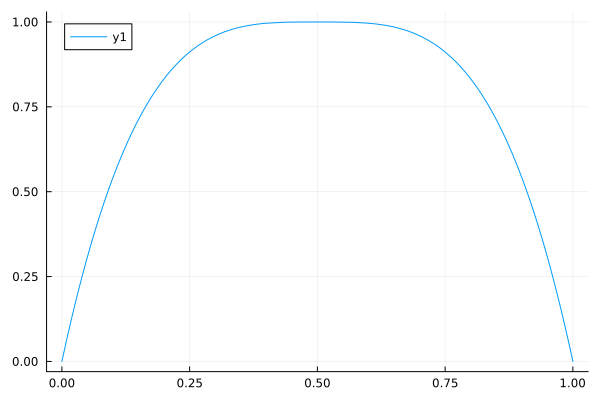

In [29]:
plot(x -> IntervalArithmetic.mid(T(x)), 0, 1)

In [30]:
PK = assemble(B, T)     

┌ Info: 257
└ @ RigorousInvariantMeasures C:\Users\isaia\.julia\packages\RigorousInvariantMeasures\xFVMn\src\Basis\Fourier\FourierCommon.jl:78
┌ Info: 128
└ @ RigorousInvariantMeasures C:\Users\isaia\.julia\packages\RigorousInvariantMeasures\xFVMn\src\Basis\Fourier\FourierCommon.jl:82
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


257×257 adjoint(::Matrix{Complex{Interval{Float64}}}) with eltype Complex{Interval{Float64}}:
             [0.999999, 1.00001] + [-1.47812e-14, 1.47812e-14]im  …         [-1.47812e-14, 1.47812e-14] + [-1.47812e-14, 1.47812e-14]im
               [0.474773, 0.474774] + [0.186617, 0.186618]im         [-0.375593, -0.375592] + [-0.0188692, -0.0188691]im
               [0.392084, 0.392085] + [0.166867, 0.166868]im         [-0.340098, -0.340097] + [-0.0599438, -0.0599437]im
               [0.349747, 0.349748] + [0.153616, 0.153617]im          [-0.31428, -0.314279] + [-0.0732259, -0.0732258]im
               [0.322351, 0.322352] + [0.144072, 0.144073]im          [-0.295305, -0.295304] + [-0.078874, -0.0788739]im
               [0.302536, 0.302537] + [0.136744, 0.136745]im      …  [-0.280603, -0.280602] + [-0.0815037, -0.0815036]im
               [0.287232, 0.287233] + [0.130862, 0.130863]im          [-0.26874, -0.268739] + [-0.0827021, -0.082702]im
               [0.274888, 0.274889] + [0.1259

The following matrix represents convolution with the noise in Fourier basis, and by the action of convolution in Fourier, it is a diagonal matrix.

In [31]:
using LinearAlgebra

σ = interval(0.1)

D = Diagonal([[exp((-σ^2 * π^2 * interval(k)^2) / 2) for k in 0:K]; [exp((-σ^2 * π^2 * interval(k)^2) / 2) for k in -K:-1]])
Dc, Dr = IntervalArithmetic.mid.(D), IntervalArithmetic.radius.(D)
bD = BallMatrix(Dc, Dr)

257×257 BallMatrix{Float64, Float64, Ball{Float64, Float64}, Diagonal{Float64, Vector{Float64}}, Diagonal{Float64, Vector{Float64}}}:
 1.0 ± 0.0  …              0.0 ± 0.0
 0.0 ± 0.0                 0.0 ± 0.0
 0.0 ± 0.0                 0.0 ± 0.0
 0.0 ± 0.0                 0.0 ± 0.0
 0.0 ± 0.0                 0.0 ± 0.0
 0.0 ± 0.0  …              0.0 ± 0.0
 0.0 ± 0.0                 0.0 ± 0.0
 0.0 ± 0.0                 0.0 ± 0.0
 0.0 ± 0.0                 0.0 ± 0.0
 0.0 ± 0.0                 0.0 ± 0.0
                                ⋮  ⋱  
 0.0 ± 0.0                 0.0 ± 0.0
 0.0 ± 0.0                 0.0 ± 0.0
 0.0 ± 0.0  …              0.0 ± 0.0
 0.0 ± 0.0                 0.0 ± 0.0
 0.0 ± 0.0                 0.0 ± 0.0
 0.0 ± 0.0                 0.0 ± 0.0
 0.0 ± 0.0                 0.0 ± 0.0
 0.0 ± 0.0  …              0.0 ± 0.0
 0.0 ± 0.0     0.95185 ± 1.11022e-16

$P_{K}$ is the Galerkin truncation of the Perron-Frobenius operator (without noise)

In [32]:
# we convert this to a BallMatrix


center = IntervalArithmetic.mid.(real.(PK)) + im * IntervalArithmetic.mid.(imag.(PK))
radius = sqrt.(IntervalArithmetic.radius.(real.(PK)) .^ 2 + IntervalArithmetic.radius.(imag.(PK)) .^ 2)

bPK = BallMatrix(center, radius)

257×257 BallMatrix{Float64, ComplexF64, Ball{Float64, ComplexF64}, Matrix{ComplexF64}, Matrix{Float64}}:
           1.0+0.0im ± 2.09716e-14  …              0.0+0.0im ± 2.09038e-14
 0.474773+0.186618im ± 2.20598e-14     -0.375593-0.0188691im ± 2.20426e-14
 0.392084+0.166868im ± 2.30804e-14     -0.340098-0.0599438im ± 2.30755e-14
 0.349748+0.153617im ± 2.45719e-14     -0.314279-0.0732258im ± 2.45621e-14
    0.322352+0.144072im ± 2.52e-14     -0.295304-0.0788739im ± 2.51902e-14
 0.302537+0.136745im ± 2.57299e-14  …  -0.280603-0.0815036im ± 2.57201e-14
 0.287233+0.130862im ± 2.81047e-14       -0.26874-0.082702im ± 2.81047e-14
 0.274888+0.125987im ± 2.88701e-14     -0.258872-0.0831447im ± 2.88701e-14
 0.264619+0.121847im ± 2.93607e-14     -0.250472-0.0831604im ± 2.93607e-14
 0.255876+0.118267im ± 2.98906e-14      -0.243193-0.0829243im ± 2.9871e-14
                                                           ⋮  ⋱  
 0.255876-0.118267im ± 2.98906e-14      -0.243193+0.0829243im ± 2.9871e-14
 0.2

In [33]:
using Plots

To get some intuition about the entries of the matrix, we plot 
$$
-log(abs(M_{ij}))
$$
i.e., the lighter color means that the entries are exponentially smaller. We start by looking at the operator for the deterministic system.

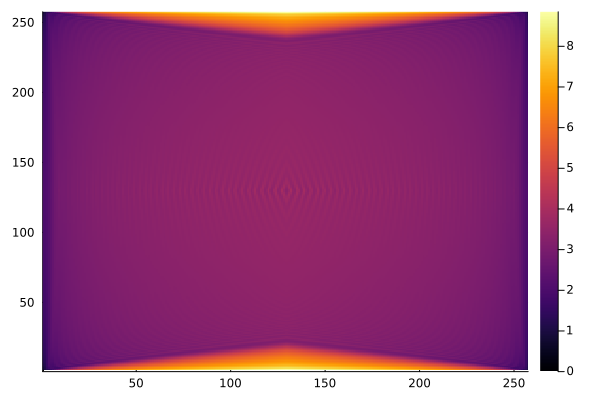

In [34]:
heatmap(-log.(abs.(BallArithmetic.mid.(bPK))))

We compute now the annealed Perron-Frobenius operator

In [35]:
PσK = bD * bPK

257×257 BallMatrix{Float64, ComplexF64, Ball{Float64, ComplexF64}, Matrix{ComplexF64}, Matrix{Float64}}:
               1.0+0.0im ± 4.23989e-14  …                 0.0+0.0im ± 4.18075e-14
     0.451913+0.177632im ± 4.23635e-14        -0.357508-0.0179606im ± 4.21679e-14
      0.32185+0.136976im ± 3.82165e-14         -0.279175-0.049206im ± 3.80713e-14
    0.224321+0.0985269im ± 3.17176e-14        -0.201573-0.0469656im ± 3.16492e-14
    0.146361+0.0654147im ± 2.30179e-14          -0.13408-0.035812im ± 2.29788e-14
   0.0881025+0.0398218im ± 1.51016e-14  …    -0.0817152-0.0237349im ± 1.50642e-14
    0.0486068+0.0221451im ± 9.5751e-15        -0.0454773-0.0139952im ± 9.5668e-15
   0.0244911+0.0112248im ± 5.18142e-15       -0.0230642-0.00740777im ± 5.1765e-15
  0.0112461+0.00517839im ± 2.51404e-15      -0.0106448-0.00353424im ± 2.51169e-15
 0.00469973+0.00217223im ± 1.10708e-15     -0.00446677-0.00152309im ± 1.10489e-15
                                                               ⋮  ⋱  
 0.00

We plot the heatmap of the modulus of the coefficients, to see the effect of the noise. Please note that we are looking at different scales for the exponent.

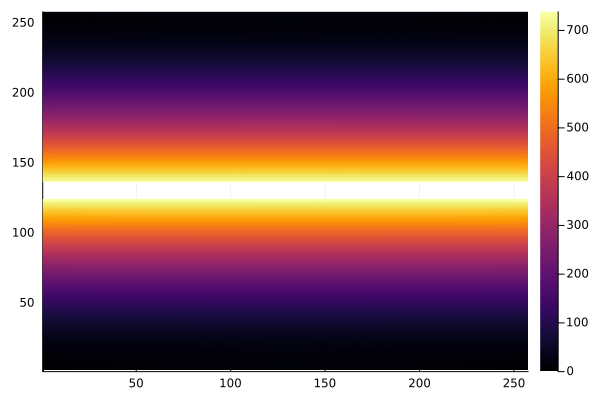

In [36]:
heatmap(-log.(abs.(BallArithmetic.mid.(PσK))))

To calculate an approximation of the fixed point of the complex matrix of intervals $P\sigma K$, we take the matrix of the centers $A$
$$(A)_{ij}=mid(real(P_{ij}))+mid(im(P_{ij}))$$
where $mid$ takes the mid point of the interval. Now we use a numerical algorithm to compute an approximation of the fixed point of $A$.
Later, we are going to compute the residual of this fixed point.

In [37]:
using LinearAlgebra

A = PσK.c 
F = eigen(A)                         

Eigen{ComplexF64, ComplexF64, Matrix{ComplexF64}, Vector{ComplexF64}}
values:
257-element Vector{ComplexF64}:
    -0.4900231549726227 - 4.163336342344337e-16im
  -0.024028583179911803 - 0.14996656065810202im
   -0.02402858317990915 + 0.14996656065810046im
 -0.0007616768736265859 - 6.194732483637177e-12im
 -5.2749370591476844e-5 - 2.070161000875755e-10im
 -1.7702603564989668e-6 + 4.2530676705709406e-9im
  -5.500748282296101e-8 + 1.5177277085165442e-7im
 -4.9141747228142024e-8 - 1.5082379620557956e-7im
 -6.8400374461351656e-9 + 1.923245409138653e-10im
 -4.803807628040773e-10 - 2.2933129553723618e-10im
                        ⋮
  3.502377625917896e-10 - 4.1465520246033687e-10im
    4.53444876822258e-7 - 6.117916371177127e-8im
   6.137247004302587e-7 + 5.627827608397299e-8im
   2.758557994966988e-5 - 1.382555649718059e-10im
 0.00044984876211457076 - 1.028331205585403e-11im
  0.0005242102853209345 - 0.008380805862641104im
  0.0005242102855571931 + 0.008380805861990684im
   0.010102934834916

We plot the eigenvalues of the matrix $A$.

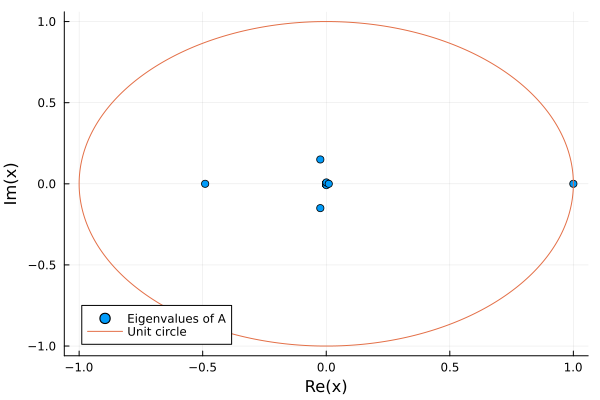

In [38]:
using Plots
scatter(F.values, label = "Eigenvalues of A")
plot!([cos(x) for x in 0:0.01:2*pi], [sin(x) for x in 0:0.01:2*pi], label = "Unit circle")

The matrix F.vectors contains numerical approximations, not verified of the eigenvalues of $A$

In [39]:
F.vectors               

257×257 Matrix{ComplexF64}:
         0.0+0.0im         …    0.862162+0.0im
    0.565836+0.0im              0.259411+0.000287363im
    0.312697-0.0901638im        0.174787+0.0509537im
    0.204878-0.0656197im        0.122907+0.0413455im
    0.128757-0.0449061im        0.080324+0.0293197im
   0.0756839-0.0279271im   …   0.0483626+0.0185373im
   0.0410568-0.0157715im       0.0266803+0.0105686im
   0.0204248-0.00808853im      0.0134412+0.00545314im
  0.00928487-0.00376644im     0.00617095+0.0025498im
  0.00384845-0.00159201im     0.00257838+0.00108097im
            ⋮              ⋱  
 0.000441255-0.0041413im      0.00257838-0.00108097im
 0.000993121-0.00997038im     0.00617095-0.0025498im
  0.00199581-0.0218772im   …   0.0134412-0.00545314im
  0.00354405-0.0438388im       0.0266803-0.0105686im
  0.00543371-0.0804888im       0.0483626-0.0185373im
  0.00674515-0.136196im         0.080324-0.0293197im
  0.00513528-0.215068im         0.122907-0.0413455im
  -0.0017452-0.325432im    …    0.174787

In [40]:
fσK = F.vectors[:, 257]   # this is going to be an approximation of our fixed point

257-element Vector{ComplexF64}:
    0.8621618559192297 + 0.0im
   0.25941132226562713 + 0.00028736283984856314im
    0.1747872046560138 + 0.0509537317406765im
   0.12290673960817561 + 0.04134552726635249im
   0.08032399031782746 + 0.02931969280076538im
   0.04836263817291529 + 0.01853726831563591im
   0.02668034785187104 + 0.010568564353046164im
  0.013441193935186689 + 0.005453135414808896im
  0.006170952671736623 + 0.002549801279743537im
  0.002578379746454175 + 0.0010809684527433377im
                       ⋮
 0.0025783797464541815 - 0.0010809684527433392im
  0.006170952671736641 - 0.0025498012797435603im
  0.013441193935186665 - 0.00545313541480886im
   0.02668034785187102 - 0.010568564353046163im
   0.04836263817291519 - 0.018537268315636107im
   0.08032399031782744 - 0.029319692800765348im
   0.12290673960817565 - 0.04134552726635241im
    0.1747872046560138 - 0.0509537317406762im
   0.25941132226562696 - 0.00028736283984858753im

$f_{\sigma,k}$ is fixed point of $A$

In [41]:
fσK /= fσK[1] # we normalize it

257-element Vector{ComplexF64}:
                   1.0 + 0.0im
   0.30088471263791294 + 0.000333304979657421im
   0.20273131252096183 + 0.059099960629028364im
     0.142556457078623 + 0.04795564427084313im
   0.09316578988777774 + 0.034007179277845655im
   0.05609461592493147 + 0.021500914460976274im
  0.030945869002085086 + 0.01225821379186168im
   0.01559010508630749 + 0.0063249555490886445im
  0.007157533854425984 + 0.0029574508107006897im
  0.002990598260352319 + 0.0012537883058985698im
                       ⋮
 0.0029905982603523266 - 0.0012537883058985715im
  0.007157533854426004 - 0.0029574508107007166im
  0.015590105086307463 - 0.006324955549088602im
   0.03094586900208507 - 0.012258213791861679im
   0.05609461592493135 - 0.021500914460976503im
   0.09316578988777773 - 0.03400717927784562im
   0.14255645707862305 - 0.04795564427084304im
   0.20273131252096183 - 0.059099960629028024im
    0.3008847126379128 - 0.0003333049796574492im

In the computer calculations, the symmetry of the point was lost. Now let's symmetrize the fixed point

In [42]:
fσKs = zeros(257) + zeros(257) * im
for i in 1:129
    fσKs[i] = fσK[i]
end

for i in 1:128
    fσKs[258-i] = conj(fσK[i+1])
end
fσKs                                

257-element Vector{ComplexF64}:
                  1.0 + 0.0im
  0.30088471263791294 + 0.000333304979657421im
  0.20273131252096183 + 0.059099960629028364im
    0.142556457078623 + 0.04795564427084313im
  0.09316578988777774 + 0.034007179277845655im
  0.05609461592493147 + 0.021500914460976274im
 0.030945869002085086 + 0.01225821379186168im
  0.01559010508630749 + 0.0063249555490886445im
 0.007157533854425984 + 0.0029574508107006897im
 0.002990598260352319 + 0.0012537883058985698im
                      ⋮
 0.002990598260352319 - 0.0012537883058985698im
 0.007157533854425984 - 0.0029574508107006897im
  0.01559010508630749 - 0.0063249555490886445im
 0.030945869002085086 - 0.01225821379186168im
  0.05609461592493147 - 0.021500914460976274im
  0.09316578988777774 - 0.034007179277845655im
    0.142556457078623 - 0.04795564427084313im
  0.20273131252096183 - 0.059099960629028364im
  0.30088471263791294 - 0.000333304979657421im


Note that
\begin{align*}
f_{\sigma,k,s}=(\mathcal{F}(f_{\sigma,k,s})[0],\mathcal{F}(f_{\sigma,k,s})[1],\ldots,\mathcal{F}(f_{\sigma,k,s})[K],\mathcal{F}(f_{\sigma,k,s})[-K],\ldots,\mathcal{F}(f_{\sigma,k,s})[-1])
\end{align*}


In [43]:
bfσKs = BallVector(fσKs)

257-element BallVector{Float64, ComplexF64, Ball{Float64, ComplexF64}, Vector{ComplexF64}, Vector{Float64}}:
                                    1.0 + 0.0im ± 0.0
   0.30088471263791294 + 0.000333304979657421im ± 0.0
   0.20273131252096183 + 0.059099960629028364im ± 0.0
      0.142556457078623 + 0.04795564427084313im ± 0.0
   0.09316578988777774 + 0.034007179277845655im ± 0.0
   0.05609461592493147 + 0.021500914460976274im ± 0.0
   0.030945869002085086 + 0.01225821379186168im ± 0.0
  0.01559010508630749 + 0.0063249555490886445im ± 0.0
 0.007157533854425984 + 0.0029574508107006897im ± 0.0
 0.002990598260352319 + 0.0012537883058985698im ± 0.0
                                                                              ⋮
 0.002990598260352319 - 0.0012537883058985698im ± 0.0
 0.007157533854425984 - 0.0029574508107006897im ± 0.0
  0.01559010508630749 - 0.0063249555490886445im ± 0.0
   0.030945869002085086 - 0.01225821379186168im ± 0.0
   0.05609461592493147 - 0.021500914460976274im ± 0.0
 

We compute now the residuals of the fixed point with respect to all the matrices in the BallMatrix

In [44]:
residual = PσK * bfσKs - bfσKs

257-element BallVector{Float64, ComplexF64, Ball{Float64, ComplexF64}, Vector{ComplexF64}, Vector{Float64}}:
                     4.440892098500626e-16 + 0.0im ± 2.5942883021439544e-13
 -2.7755575615628914e-16 - 6.646701418422385e-16im ± 2.6237305680994864e-13
  -4.718447854656915e-16 - 4.0245584642661925e-16im ± 2.367155095895588e-13
  -3.608224830031759e-16 - 7.632783294297951e-17im ± 1.9631551561356548e-13
 -2.498001805406602e-16 - 1.8735013540549517e-16im ± 1.4253205170120918e-13
   -8.326672684688674e-17 + 1.5265566588595902e-16im ± 9.32961750061354e-14
  -6.591949208711867e-17 + 1.5612511283791264e-17im ± 5.916888134225837e-14
  -2.0816681711721685e-17 - 8.673617379884035e-19im ± 3.199448768222314e-14
 -4.0766001685454967e-17 + 1.2576745200831851e-17im ± 1.552882269321284e-14
   -2.168404344971009e-18 - 2.168404344971009e-18im ± 6.832998096736467e-15
                                                                                                    ⋮
 -2.6020852139652106e-18 + 3.

In [45]:
import Pkg
Pkg.add("FFTW")

   Resolving package versions...
  No Changes to `C:\Users\isaia\Code\HSI2025\Project.toml`
  No Changes to `C:\Users\isaia\Code\HSI2025\Manifest.toml`


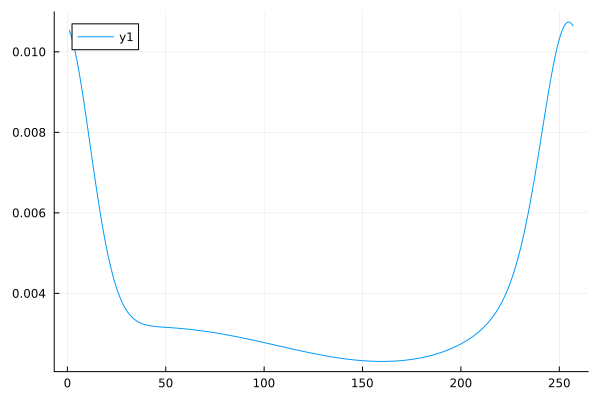

In [46]:
using FFTW
plot(real.(ifft(BallArithmetic.mid(bfσKs))))

In [47]:
ϵ = norm(residual.c, 2) + norm(residual.r, 2)

6.822153659832245e-13

Now to limit $\|f_{\sigma}-f_{\sigma,k,s}\|$ we use the following result

Let $f_{\sigma}$ be the unique fixed point of $L_{\sigma}$ and $f_{\sigma,k}$ be the unique fixed point of $L_{\sigma,k}$ and $f_{\sigma,k,s}$ symmetrization of $f_{k,s}$. Suppose that there exists $n \in \mathbb{N}$ and $\eta>0$ such that 
\begin{align*}
\|L_{\sigma,k }^{n}|_{V}\|_{L^{2}\rightarrow L^{2}}\leq \eta <1,	
\end{align*}
where $V$ be the zero average subspace of $L^{2}$, then if $1\leq C_i $ are such that $\|L^i_{\sigma,k}|_V\|_{L^{2}\rightarrow L^{2}}\leq C_i$ for $1\leq i \leq n-1$, we have
\begin{align*}
\|f_{\sigma}-f_{\sigma,k,s}\|_{L^{2}}\leq \frac{1}{1-\eta}\displaystyle \sum _{i=0}^{n-1}C_i((1+\Gamma_{\sigma,k}+\|\rho_{\sigma}\|_{L^{2}})\Gamma_{\sigma,k}\|f_{\sigma}\|_{L^1}+\epsilon).
\end{align*}

Remark that $\epsilon$ is the residual with respect to the approximation of the fixed point.

In [48]:
σ = interval(σ)
Γ = ((1 / (sqrt(σ^2 * 2 * interval(π))))exp((-σ^2 * K^2 * interval(π)^2) / 2))   #para σ=0,1 e K=128, Γ=3.03*10^(-702)

[0, 1.97627e-323]

We apply now the Theorem, by computing bounds for the norm of the operator restricted to the space of average $0$ measures.

In [ ]:
A = PσK[2:end, 2:end]

Aiter = A

C = zeros(10)
η = 0
n_0 = 0
for n in 1:10
    C[n] = BallArithmetic.svd_bound_L2_opnorm(Aiter)
    Aiter *= A 
end
η, C

(0.9192775043144087, [1.1899603133820773, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [50]:
ρ1 = 1 / (sqrt(σ^2 * 2 * interval(π)))
ρn = sqrt(ρ1)


[1.99735, 1.99736]

In [51]:
#ya tenho ϵ, os C_i, η,h, n_1 é dizer ate onde vai asumatoria, |u|=1, e usei PK o operador de tranferencia finito, pero creo que tiene que ser el operador de transferencia infinito, só me falta K
R_1 = 0                                             #ja tenho todos os valos que preciso ahora só resta fazer a sumatoria
for i in 1:n_1-1
    global R_1 = R_1 + C[i] * ((1 + Γ + ρn)Γ + ϵ)
end
R_1 = (1 / (1 - η)) * R_1

[1.00567e-11, 1.00568e-11]

We will use the following approximation to find the value of the lyaponov exponent $λ(\alpha,\beta,σ)$.
Let $\alpha$ and $\beta$ be fixed, then
\begin{align*}
	|\lambda(\alpha,\beta,\sigma)-\lambda(\alpha,\beta,\sigma,k,s)|\leq \Upsilon \|f_{\sigma}-f_{\sigma,k,s}\|_{L^2}.
\end{align*}
where $f_{\sigma,k,s}$ is a symmetric trigonometric polynomial that approximates the fixed point of $P_{\sigma, K}$ and $\Upsilon = \sqrt{2}((\ln((1+\beta)\alpha)-(\alpha-1))^2+(\alpha-1)^2)^{\frac{1}{2}}$.

In [67]:
Υ = sqrt(interval(2)) * ((log2((β + 1) * α) - (α - 1))^2 + (α - 1)^2)^(1 / 2)

[3.56215, 3.56216]

# Computing the Fourier Expansion of the observable

In [28]:
Iπ = interval(π)

[3.14159, 3.1416]

To compute the value of the Lyapunov exponent we need to find an enclosure of the Fourier coefficients of 
$$
\ln|T'_{\alpha,\beta}|
$$

I already have bounded $|\lambda(\alpha,\beta,\sigma)-\lambda(\alpha,\beta,\sigma,k,s)|$, it remains to find $\lambda(\alpha,\beta,\sigma,k,s)$ but 
\begin{align*}
\lambda (\alpha,\beta,\sigma,k,s)&=\int_{-1}^{1}\ln|T'_{\alpha,\beta}|f_{\sigma,k,s}dm\\
&=\langle \ln|T'_{\alpha,\beta}|,f_{\sigma,k,s} \rangle\\
&=\displaystyle \sum_{j=-k}^{k}\mathcal{F}(\ln|T'_{\alpha,\beta}|)[j]\mathcal{F}(f_{\sigma,k,s})[j].
\end{align*}
$\mathcal{F}(f_{\sigma,k})[j]$ we have already calculated it, let's calculate $\mathcal{F}(\ln|T'_{\alpha,\beta}|)[j]$.

We now that

\begin{align*}
\mathcal{F}(ln|T'_{\alpha,\beta}|)[0]&=\ln (2\alpha \beta)-(\alpha-1)\\
\mathcal{F}(ln|T'_{\alpha,\beta}|)[j]&=-\frac{(\alpha-1)}{j\pi}\int_{0}^{1}\frac{1}{x}sen(j\pi x)dx\\
&=-\frac{(\alpha-1)}{j\pi}\int _{0}^{j\pi}\frac{sen(x)}{x}dx.
\end{align*}

We want to compute
$$
\frac{1}{j\pi}\int_0^{j\pi} \frac{sin(t)}{t}dt
$$
for $j\geq 1$ by using Taylor Models integration for $[\pi, j\pi]$.

To make the computation more efficient, we will 
compute 
$$
I_i = \int_{i\pi}^{(i+1)\pi}\frac{sin(t)}{t}dt
$$

In [57]:
f(t) = sin(t) / t

f (generic function with 1 method)

The  power series for $f$ at $x=0$ is
$$
f(x) = \sum_{i=0}^{+\infty}(-1)^i\frac{x^{2i}}{(2i+1)!}
$$
Then, the power series for the primitive is 
$$
F(x) = \sum_{i=0}^{+\infty}(-1)^i\frac{x^{2i+1}}{(2i+1)!(2i+1)}.
$$
We are going to use this Taylor series to approximate the integral only in the interval $[0, \pi]$.

We will bound the remainder of the series by using the alternating series remainder.

In [52]:
function coeff_eval_at_0(i, x)
    return x^(2i + 1) / (factorial(big(2i + 1)) * (2i + 1))
end

coeff_eval_at_0 (generic function with 1 method)

In [53]:
using IntervalArithmetic                                #No usa aqui Taylor Model porque no existe su serie de taylor pues la serie de taylor lo hace sacando la derivada y evaluando a en nuestro caro a=0, pero nosotros tenemos sen(t)/t el cual al derivar siempre tendra dividido por t^n y no se va poder remprazar para t=0
N = 1000

Pi = @biginterval π                                     # @interval(1)=[1,1], @interval(0.1)=[0.1,0.100001], @interval(x)= um intervalo fechado pequeno que contega x, @interval(1,2)=[1,2],@biginterval(1,2)=[1,2]_256 creo que va aceptar por ejemplo un decimal hasta la cifra 256
v = [(-1)^i * coeff_eval_at_0(i, Pi) for i in 0:N]        # como ja integro agora tem que valiar em \pi e 0, em verdad seria em jπ, mas ta tomando no intervalo [0,π] de momento
# i.e esta achando (-1)^{i}a_K, e os vota emcada coordenada de v, note que cada coordenadas é um intervalo pois Pi
error = Interval(-1, 1) * abs(coeff_eval_at_0(N + 1, Pi))   # error=[-a_{K+1},a_{K+1}], esto se tiene de Alternating series estimation theorem
@info error

integral_with_error = sum(v) + error                      # aqui esta sumando os primeros (-1)a_K + error e vai me sair um inervalo
integral_with_error, diam(integral_with_error)          # o diametri do intervalo que tem que ser muito pequeno

┌ Info: [-1.16004e-4753, 1.16004e-4753]₂₅₆
└ @ Main c:\Users\isaia\Code\HSI2025\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y121sZmlsZQ==.jl:8


([1.85193, 1.85194]₂₅₆, 1.746233281840096703253120346658240793279655273689016096051792841668089262599443e-74)

Therefore, we have computed $I_0$. We will now use 
Taylormodels to compute the value of the integrals
$$
\int_{i\pi}^{(i+1)\pi}\frac{sin(t)}{t}dt
$$
for $i>0$.

In [54]:
#import Pkg; Pkg.add("TaylorModels")
using TaylorModels

In [55]:
function integrate_i_i_plus_1(f, i; degree=40)            #aqui puede usar porque evalua las derivadas em m que es diferente de 0
    I = (@interval i * π (i + 1) * π)                             #esto es el intervalo [i*π,(i+1)*π], i>0
    m = Interval(IntervalArithmetic.mid(I))                                    #mid(I) ponto medio do intervalo I, Interval(mid(I))=un intervalo pequenho que contenga mid(I)
    tm = TaylorModel1(degree, m, I)                         #ese m es el valor que será evaluada en la serie de Taylos i.e f(m)+f'(m)t/1!+...+f^{(400)}(m)t^{400}/400!+erro
    prim = TaylorSeries.integrate(f(tm))                    #esto es la primitiva de f, al poner f(tm), recien esta diciendo quien va ser la función f para la cual voy hacer el polinomi de taylor i.e. para obtener la sumatoria que esta en la linea de arriba
    return prim(I.hi - m) - prim(I.lo - m)                        #I.hi, I.lo parte superior e inferior do intervalo I respectivamente, como m é um intervalo, vai ficar o intevalo prim([I.hi-m1,I.hi-m2])-prim([I.lo-m1,I.lo-m2]) where denotamos m=[m1,m2]
end

integrate_i_i_plus_1 (generic function with 1 method)

The vector `val` is containing at index $i$
the value of the integral
$$
\int_{i\pi}^{(i+1)\pi} \frac{\sin(t)}{t}dt
$$

In [58]:
val = [integral_with_error; [integrate_i_i_plus_1(f, i) for i in 1:K-1]] #aqui junta I_0+el resultado de la integrales [π,2π],[2π,3π],...,[2000π,2001π], en un vector

128-element Vector{Interval{BigFloat}}:
  [1.85193, 1.85194]₂₅₆
 [-0.433786, -0.433785]₂₅₆
  [0.25661, 0.256611]₂₅₆
 [-0.182601, -0.1826]₂₅₆
  [0.141803, 0.141804]₂₅₆
 [-0.115931, -0.11593]₂₅₆
  [0.0980515, 0.0980516]₂₅₆
 [-0.0849543, -0.0849542]₂₅₆
  [0.0749456, 0.0749457]₂₅₆
 [-0.0670479, -0.0670478]₂₅₆
   ⋮
 [-0.00532738, -0.00532737]₂₅₆
  [0.00528316, 0.00528317]₂₅₆
 [-0.00523969, -0.00523968]₂₅₆
  [0.00519691, 0.00519692]₂₅₆
 [-0.00515484, -0.00515483]₂₅₆
  [0.00511342, 0.00511343]₂₅₆
 [-0.00507269, -0.00507268]₂₅₆
  [0.00503258, 0.00503259]₂₅₆
 [-0.00499312, -0.00499311]₂₅₆

In [59]:
maximum(diam.(val))

1.609823385706476983614265918731689453125e-15

The cumulative sum vector below contains at the $i$-th index the value of the integral
$$
\int_0^{i\pi}\frac{\sin(t)}{t}dt
$$

In [60]:
cum_sum = cumsum(val)               #cumsum en cada coornenada suma lo anterior y lo pone ahí ejemplo v=(v_1,v_2,v_3,v_4)=(v_1,v_1+v_2,v_1+v_2+v_3,v_1+v_2+v_3+v_4)

128-element Vector{Interval{BigFloat}}:
 [1.85193, 1.85194]₂₅₆
 [1.41815, 1.41816]₂₅₆
 [1.67476, 1.67477]₂₅₆
 [1.49216, 1.49217]₂₅₆
 [1.63396, 1.63397]₂₅₆
 [1.51803, 1.51804]₂₅₆
 [1.61608, 1.61609]₂₅₆
 [1.53113, 1.53114]₂₅₆
 [1.60607, 1.60608]₂₅₆
 [1.53902, 1.53903]₂₅₆
  ⋮
 [1.56814, 1.56815]₂₅₆
 [1.57342, 1.57343]₂₅₆
 [1.56818, 1.56819]₂₅₆
 [1.57338, 1.57339]₂₅₆
 [1.56822, 1.56823]₂₅₆
 [1.57334, 1.57335]₂₅₆
 [1.56827, 1.56828]₂₅₆
 [1.5733, 1.57331]₂₅₆
 [1.5683, 1.56831]₂₅₆

The vector `coeff` contains at the index $i$ the value of
$$
\frac{1}{i\pi}\int_0^{i\pi} \frac{\sin(t)}{t}dt.
$$

In [61]:
coeff = cum_sum ./ ([i * @interval π for i in 1:K])         #aqui solo le esta dividiendo por iπ a cada integral

128-element Vector{Interval{BigFloat}}:
 [0.589489, 0.58949]₂₅₆
 [0.225705, 0.225706]₂₅₆
 [0.177697, 0.177698]₂₅₆
 [0.118742, 0.118743]₂₅₆
 [0.104021, 0.104022]₂₅₆
 [0.0805342, 0.0805343]₂₅₆
 [0.0734879, 0.073488]₂₅₆
 [0.0609217, 0.0609218]₂₅₆
 [0.0568033, 0.0568034]₂₅₆
 [0.0489888, 0.0489889]₂₅₆
  ⋮
 [0.00415963, 0.00415964]₂₅₆
 [0.00413915, 0.00413916]₂₅₆
 [0.00409155, 0.00409156]₂₅₆
 [0.00407173, 0.00407174]₂₅₆
 [0.00402566, 0.00402567]₂₅₆
 [0.00400648, 0.00400649]₂₅₆
 [0.00396187, 0.00396188]₂₅₆
 [0.00394328, 0.00394329]₂₅₆
 [0.00390006, 0.00390007]₂₅₆

I want
\begin{align*}
\mathcal{F}(ln|T'_{\alpha,\beta}|)[0]&=\ln ((1+\beta)\alpha)-(\alpha-1)\\
\mathcal{F}(ln|T'_{\alpha,\beta}|)[j]&=-\frac{(\alpha-1)}{j\pi}\int_{0}^{1}\frac{1}{x}sen(j\pi x)dx\\
&=-\frac{(\alpha-1)}{j\pi}\int _{0}^{j\pi}\frac{sen(x)}{x}dx.
\end{align*}
then

These are only the positive frequencies, so, we need to 
think about how to complete the vectore before taking the IFFT. 

In [62]:
coeff_fft = [coeff; reverse(coeff[1:end])] #hallamos la mitad, ahora como es simetrico tamos escribiendo la otra mitad que falta ussando lo que ya tenemos

256-element Vector{Interval{BigFloat}}:
 [0.589489, 0.58949]₂₅₆
 [0.225705, 0.225706]₂₅₆
 [0.177697, 0.177698]₂₅₆
 [0.118742, 0.118743]₂₅₆
 [0.104021, 0.104022]₂₅₆
 [0.0805342, 0.0805343]₂₅₆
 [0.0734879, 0.073488]₂₅₆
 [0.0609217, 0.0609218]₂₅₆
 [0.0568033, 0.0568034]₂₅₆
 [0.0489888, 0.0489889]₂₅₆
  ⋮
 [0.0568033, 0.0568034]₂₅₆
 [0.0609217, 0.0609218]₂₅₆
 [0.0734879, 0.073488]₂₅₆
 [0.0805342, 0.0805343]₂₅₆
 [0.104021, 0.104022]₂₅₆
 [0.118742, 0.118743]₂₅₆
 [0.177697, 0.177698]₂₅₆
 [0.225705, 0.225706]₂₅₆
 [0.589489, 0.58949]₂₅₆

We need now to take into account the constants $\alpha$ and $\beta$

In [63]:
ln = [log((1 + β) * α) - (α - 1); -(α - 1) * coeff_fft]  

257-element Vector{Interval{BigFloat}}:
 [-0.55409, -0.554089]₂₅₆
 [-1.47373, -1.47372]₂₅₆
 [-0.564265, -0.564264]₂₅₆
 [-0.444245, -0.444244]₂₅₆
 [-0.296857, -0.296856]₂₅₆
 [-0.260054, -0.260053]₂₅₆
 [-0.201336, -0.201335]₂₅₆
 [-0.18372, -0.183719]₂₅₆
 [-0.152305, -0.152304]₂₅₆
 [-0.142009, -0.142008]₂₅₆
   ⋮
 [-0.142009, -0.142008]₂₅₆
 [-0.152305, -0.152304]₂₅₆
 [-0.18372, -0.183719]₂₅₆
 [-0.201336, -0.201335]₂₅₆
 [-0.260054, -0.260053]₂₅₆
 [-0.296857, -0.296856]₂₅₆
 [-0.444245, -0.444244]₂₅₆
 [-0.564265, -0.564264]₂₅₆
 [-1.47373, -1.47372]₂₅₆

Since these were the coefficients computed on the Fourier basis of $[-1,1]$ we need to convert them to the coefficients in the Fourier Basis of $[0,1]$,
i.e., we need to apply the coordinate change.

In [64]:
lnn = zeros(Interval, 257) #2*K+1
lnn[1] = ln[1]
for i in 2:129
    lnn[i] = (-1)^(i + 1) * ln[i]
end
for i in 130:257
    lnn[i] = (-1)^(i) * ln[i]
end
IntervalArithmetic.mid.(lnn[1:10])

10-element Vector{BigFloat}:
 -0.55408985094468665710820687309023924171924591064453125
  1.473724680590209041076980177390027844590372816605206698704616123222914587525631
 -0.5642645834876753803095431564153812880035676273970467547636290280855152214809341
  0.4442443646818932980782779723433063681265083207188845384076830624784711068336347
 -0.2968560436772844154464813963893048737572071371519050564943305027176029545611116
  0.2600535820956542355377282868106769370347884112833443901264715771484290576347021
 -0.2013355072907279590344548253986138016388467181729300645925040762422166938702733
  0.1837199989726090084462220225816129193471935374666277468325879372574944467414919
 -0.1523044453305687348361016999866777010047705607866674933993147861658668704588732
  0.1420083757324992802798566818260271725339171018589546009829085463509149607806938

\begin{align*}
ln=(\mathcal{F}(\ln|T'_{\alpha,\beta}|)[0],\mathcal{F}(\ln|T'_{\alpha,\beta}|)[1],\ldots,\mathcal{F}(\ln|T'_{\alpha,\beta}|)[K],\mathcal{F}(\ln|T'_{\alpha,\beta}|)[-K],\ldots,\mathcal{F}(\ln|T'_{\alpha,\beta}|)[-1])
\end{align*}

Finally
\begin{align*}
\lambda (\alpha,\beta,\sigma,k)=\displaystyle \sum_{j=-k}^{k}\mathcal{F}(\ln|T'_{\alpha,\beta}|)[j]\mathcal{F}(f_{\sigma,k})[j].
\end{align*}


In [65]:
λ_k = 0 + im * 0
for i in 1:2*K+1
    λ_k = lnn[i] * fσKs[i] + λ_k
end
λ_k  

[0.196215, 0.196216]₂₅₆ + [-1.35729e-16, 1.35729e-16]₂₅₆im

In [68]:
#el intervalo donde estaria λ seria
@biginterval(real.(λ_k) - Υ * R_1, real.(λ_k) + Υ * R_1) + im * @biginterval(imag.(λ_k) - Υ * R_1, imag.(λ_k) + Υ * R_1)

[0.196215, 0.196216]₂₅₆ + [-3.5824e-11, 3.5824e-11]₂₅₆im

We can observe that the integral must be a real number, so, we can restrict the enclosure to the real line

In [69]:
@biginterval(real.(λ_k) - Υ * R_1, real.(λ_k) + Υ * R_1)

[0.196215, 0.196216]₂₅₆